In [21]:
location = '/media/scottzhuang/data/MD/msm/WT/'
from msmbuilder.dataset import dataset
xyz = dataset('/media/scottzhuang/data/MD/msm/WT' + "/4NPQ*.xtc",
              topology='/media/scottzhuang/data/MD/msm/4NPQ_pH70_md5.pdb',
              stride=1)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 10
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

3 trajectories
with length {600, 810, 680} ns


In [22]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, location + '2diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

ValueError: File exists: /media/scottzhuang/data/MD/msm/WT/2diheds/

In [24]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, location + 'scaled_diheds_2/', fmt='dir-npy')

print(diheds[0].shape)
print(scaled_diheds[0].shape)

(110, 416)
(110, 416)


In [42]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=1, n_components=5)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, location + 'ticas_3/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(110, 416)
(110, 5)


/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (110). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (107). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: Us

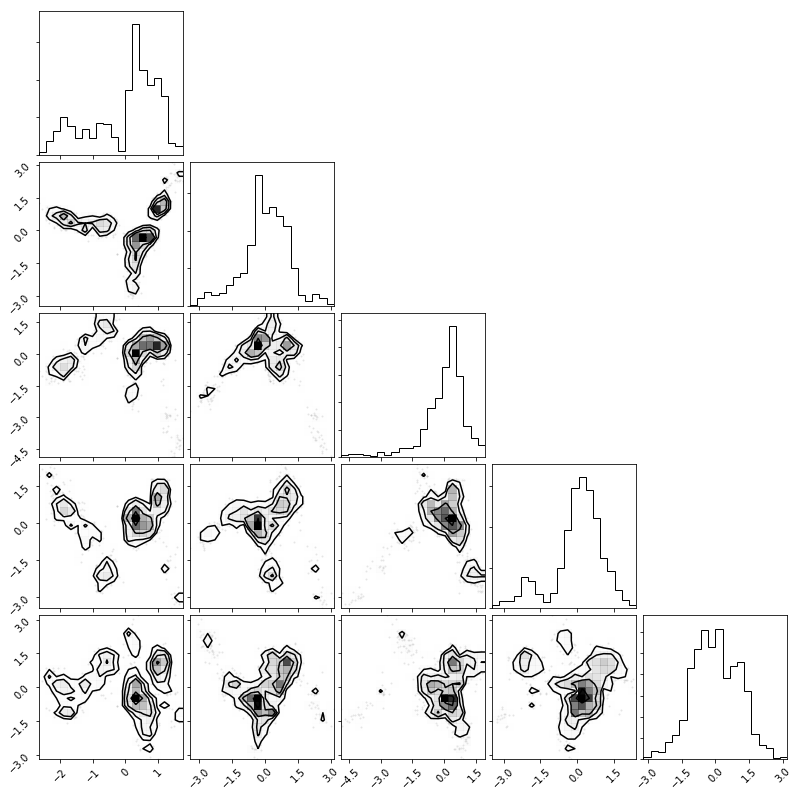

In [43]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx)

In [44]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, location + 'kmeans_3/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(110, 5)
(110,)


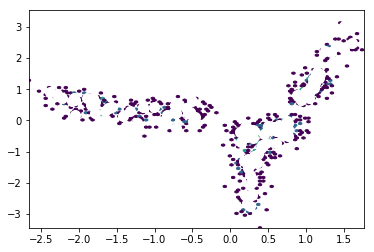

In [45]:
from matplotlib import pyplot as plt
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [46]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=1, n_timescales=5)
msm.fit(clustered_trajs)

MSM contains 6 strongly connected components above weight=1.00. Component 1 selected, with population 42.110553%


MarkovStateModel(ergodic_cutoff='on', lag_time=1, n_timescales=5,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [47]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

IndexError: too many indices for array

In [48]:
msm.timescales_

array([ 33.99016558,   8.32691899,   4.62244557,   2.54850115,   2.39546676])

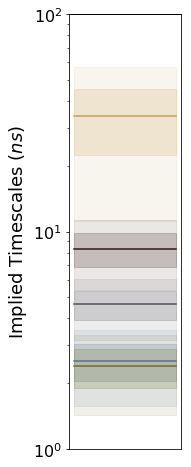

In [49]:
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

In [50]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.462342
         Iterations: 9
         Function evaluations: 89


ValueError: a and p must have same size

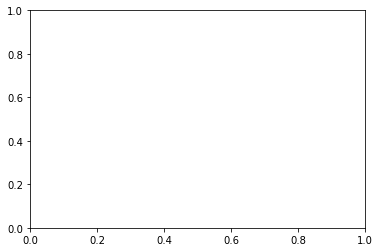

In [56]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments[0]],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()